In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataframe = pd.read_csv('log2.csv')
dataframe.shape
dataframe.head()

,duration,protocol_type,service,src_bytes,dst_bytes,flag,land,wrong_fragment,urgent,hot,...,unknown_data2,unknown_data3,unknown_data4,unknown_data5,unknown_data6,unknown_data7,unknown_data8,unknown_data9,unknown_data10,results
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [3]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("results")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)
    
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

Input: {'duration': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'protocol_type': <tf.Tensor: shape=(), dtype=string, numpy=b'tcp'>, 'service': <tf.Tensor: shape=(), dtype=string, numpy=b'private'>, 'src_bytes': <tf.Tensor: shape=(), dtype=string, numpy=b'S0'>, 'dst_bytes': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'flag': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'land': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'wrong_fragment': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'urgent': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hot': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_failed_logins': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'logged_in': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_compromised': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'root_shell': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'su_attempted': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_root': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_file_creations': <tf.Tensor: shape

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    index = StringLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    index.adapt(feature_ds)

    encoded_feature = index(feature)

    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = feature_ds.map(index)

    encoder.adapt(feature_ds)

    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    encoder.adapt(feature_ds)

    encoded_feature = encoder(feature)
    return encoded_feature

In [6]:
duration = keras.Input(shape=(1,), name="duration")
protocol_type = keras.Input(shape=(1,), name="protocol_type", dtype="string")
service = keras.Input(shape=(1,), name="service", dtype="string")
src_bytes = keras.Input(shape=(1,), name="src_bytes", dtype="string")
dst_bytes = keras.Input(shape=(1,), name="dst_bytes")
flag = keras.Input(shape=(1,), name="flag")
land = keras.Input(shape=(1,), name="land")
wrong_fragment = keras.Input(shape=(1,), name="wrong_fragment")
urgent = keras.Input(shape=(1,), name="urgent")
hot = keras.Input(shape=(1,), name="hot")
num_failed_logins = keras.Input(shape=(1,), name="num_failed_logins")
logged_in = keras.Input(shape=(1,), name="logged_in")
num_compromised = keras.Input(shape=(1,), name="num_compromised")
root_shell = keras.Input(shape=(1,), name="root_shell")
su_attempted = keras.Input(shape=(1,), name="su_attempted")
num_root = keras.Input(shape=(1,), name="num_root")
num_file_creations = keras.Input(shape=(1,), name="num_file_creations")
num_shells = keras.Input(shape=(1,), name="num_shells")
num_access_files = keras.Input(shape=(1,), name="num_access_files")
num_outbound_cmds = keras.Input(shape=(1,), name="num_outbound_cmds")
is_hot_login = keras.Input(shape=(1,), name="is_hot_login")
is_guest_login = keras.Input(shape=(1,), name="is_guest_login")
count = keras.Input(shape=(1,), name="count")
serror_rate = keras.Input(shape=(1,), name="serror_rate")
rerror_rate = keras.Input(shape=(1,), name="rerror_rate")
same_srv_rate = keras.Input(shape=(1,), name="same_srv_rate")
diff_srv_rate = keras.Input(shape=(1,), name="diff_srv_rate")
srv_count = keras.Input(shape=(1,), name="srv_count")
srv_serror_rate = keras.Input(shape=(1,), name="srv_serror_rate")
srv_rerror_rate = keras.Input(shape=(1,), name="srv_rerror_rate")
srv_diff_host_rate = keras.Input(shape=(1,), name="srv_diff_host_rate")
# unknown_data1 = keras.Input(shape=(1,), name="unknown_data1")
# unknown_data2 = keras.Input(shape=(1,), name="unknown_data2")
# unknown_data3 = keras.Input(shape=(1,), name="unknown_data3")
# unknown_data4 = keras.Input(shape=(1,), name="unknown_data4")
# unknown_data5 = keras.Input(shape=(1,), name="unknown_data5")
# unknown_data6 = keras.Input(shape=(1,), name="unknown_data6")
# unknown_data7 = keras.Input(shape=(1,), name="unknown_data7")
# unknown_data8 = keras.Input(shape=(1,), name="unknown_data8")
# unknown_data9 = keras.Input(shape=(1,), name="unknown_data9")
# unknown_data10 = keras.Input(shape=(1,), name="unknown_data10")


all_inputs = [duration,
              protocol_type, 
              service, 
              src_bytes, 
              dst_bytes, 
              flag, 
              land, 
              wrong_fragment,
              urgent,
              hot, 
              num_failed_logins, 
              logged_in, 
              num_compromised, 
              root_shell, 
              su_attempted, 
              num_root, 
              num_file_creations,
              num_shells, 
              num_access_files, 
              num_outbound_cmds, 
              is_hot_login, 
              is_guest_login,
              count, 
              serror_rate, 
              rerror_rate, 
              same_srv_rate, 
              diff_srv_rate, 
              srv_count, 
              srv_serror_rate, 
              srv_rerror_rate, 
              srv_diff_host_rate,
#               unknown_data1,
#               unknown_data2,
#               unknown_data3,
#               unknown_data4,
#               unknown_data5,
#               unknown_data6,
#               unknown_data7,
#               unknown_data8,
#               unknown_data9,
#               unknown_data10
             ]

In [7]:
duration_encoded = encode_numerical_feature(duration, "duration", train_ds)

protocol_type_encoded = encode_string_categorical_feature(protocol_type,"protocol_type", train_ds)
service_encoded = encode_string_categorical_feature(service, "service", train_ds)
src_bytes_encoded = encode_string_categorical_feature(src_bytes,"src_bytes", train_ds)


dst_bytes_encoded = encode_numerical_feature(dst_bytes,"dst_bytes", train_ds)
flag_encoded = encode_numerical_feature(flag, "flag", train_ds)
land_encoded = encode_numerical_feature(land, "land", train_ds)
wrong_fragment_encoded = encode_numerical_feature(wrong_fragment, "wrong_fragment", train_ds)
urgent_encoded = encode_numerical_feature(urgent, "urgent", train_ds)
hot_encoded = encode_numerical_feature(hot, "hot", train_ds)
num_failed_logins_encoded = encode_numerical_feature(num_failed_logins, "num_failed_logins", train_ds)
logged_in_encoded = encode_numerical_feature(logged_in, "logged_in", train_ds)
num_compromised_encoded = encode_numerical_feature(num_compromised, "num_compromised", train_ds)
root_shell_encoded = encode_numerical_feature(root_shell, "root_shell", train_ds)
su_attempted_encoded = encode_numerical_feature(su_attempted, "su_attempted", train_ds)
num_root_encoded = encode_numerical_feature(num_root, "num_root", train_ds)
num_file_creations_encoded = encode_numerical_feature(num_file_creations, "num_file_creations", train_ds)
num_shells_encoded = encode_numerical_feature(num_shells, "num_shells", train_ds)
num_access_files_encoded = encode_numerical_feature(num_access_files, "num_access_files", train_ds)
num_outbound_cmds_encoded = encode_numerical_feature(num_outbound_cmds, "num_outbound_cmds", train_ds)
is_hot_login_encoded = encode_numerical_feature(is_hot_login, "is_hot_login", train_ds)
is_guest_login_encoded = encode_numerical_feature(is_guest_login, "is_guest_login", train_ds)
count_encoded = encode_numerical_feature(count, "count", train_ds)
serror_rate_encoded = encode_numerical_feature(serror_rate, "serror_rate", train_ds)
rerror_rate_encoded = encode_numerical_feature(rerror_rate, "rerror_rate", train_ds)
same_srv_rate_encoded = encode_numerical_feature(same_srv_rate, "same_srv_rate", train_ds)
diff_srv_rate_encoded = encode_numerical_feature(diff_srv_rate, "diff_srv_rate", train_ds)
srv_count_encoded = encode_numerical_feature(srv_count, "srv_count", train_ds)
srv_serror_rate_encoded = encode_numerical_feature(srv_serror_rate, "srv_serror_rate", train_ds)
srv_rerror_rate_encoded = encode_numerical_feature(srv_rerror_rate, "srv_rerror_rate", train_ds)
srv_diff_host_rate_encoded = encode_numerical_feature(srv_diff_host_rate, "srv_diff_host_rate", train_ds)
# unknown_data1_encoded = encode_numerical_feature(unknown_data1, "unknown_data1", train_ds)
# unknown_data2_encoded = encode_numerical_feature(unknown_data2, "unknown_data2", train_ds)
# unknown_data3_encoded = encode_numerical_feature(unknown_data3, "unknown_data3", train_ds)
# unknown_data4_encoded = encode_numerical_feature(unknown_data4, "unknown_data4", train_ds)
# unknown_data5_encoded = encode_numerical_feature(unknown_data5, "unknown_data5", train_ds)
# unknown_data6_encoded = encode_numerical_feature(unknown_data6, "unknown_data6", train_ds)
# unknown_data7_encoded = encode_numerical_feature(unknown_data7, "unknown_data7", train_ds)
# unknown_data8_encoded = encode_numerical_feature(unknown_data8, "unknown_data8", train_ds)
# unknown_data9_encoded = encode_numerical_feature(unknown_data9, "unknown_data9", train_ds)
# unknown_data10_encoded = encode_numerical_feature(unknown_data10, "unknown_data10", train_ds)



all_features = layers.concatenate(
    [
        duration_encoded,
        protocol_type_encoded, 
        service_encoded, 
        src_bytes_encoded, 
        dst_bytes_encoded,
        flag_encoded, 
        land_encoded, 
        wrong_fragment_encoded,
        urgent_encoded,
        hot_encoded, 
        num_failed_logins_encoded, 
        logged_in_encoded, 
        num_compromised_encoded, 
        root_shell_encoded, 
        su_attempted_encoded, 
        num_root_encoded, 
        num_file_creations_encoded,
        num_shells_encoded, 
        num_access_files_encoded, 
        num_outbound_cmds_encoded, 
        is_hot_login_encoded, 
        is_guest_login_encoded,
        count_encoded, 
        serror_rate_encoded, 
        rerror_rate_encoded, 
        same_srv_rate_encoded, 
        diff_srv_rate_encoded, 
        srv_count_encoded, 
        srv_serror_rate_encoded, 
        srv_rerror_rate_encoded, 
        srv_diff_host_rate_encoded,
#         unknown_data1_encoded,
#         unknown_data2_encoded,
#         unknown_data3_encoded,
#         unknown_data4_encoded,
#         unknown_data5_encoded,
#         unknown_data6_encoded,
#         unknown_data7_encoded,
#         unknown_data8_encoded,
#         unknown_data9_encoded,
#         unknown_data10_encoded,

    ]
)

In [8]:
x = layers.Dense(7, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)

x1 = layers.Dense(32, activation="relu")(x)
x1 = layers.Dropout(0.5)(x1)

output = layers.Dense(1, activation="sigmoid")(x1)

model = keras.Model(all_inputs, output)

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
protocol_type (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
service (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
src_bytes (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
duration (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

In [15]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/20
12351/12351 [==============================] - 66s 5ms/step - loss: 0.0853 - accuracy: 0.9435 - val_loss: 0.0127 - val_accuracy: 0.9947
Epoch 2/20
12351/12351 [==============================] - 67s 5ms/step - loss: 0.0833 - accuracy: 0.9449 - val_loss: 0.0134 - val_accuracy: 0.9948
Epoch 3/20
12351/12351 [==============================] - 71s 5ms/step - loss: 0.0830 - accuracy: 0.9492 - val_loss: 0.0116 - val_accuracy: 0.9948
Epoch 4/20
12351/12351 [==============================] - 69s 5ms/step - loss: 0.0693 - accuracy: 0.9604 - val_loss: 0.0119 - val_accuracy: 0.9949
Epoch 5/20
12351/12351 [==============================] - 69s 5ms/step - loss: 0.0679 - accuracy: 0.9617 - val_loss: 0.0119 - val_accuracy: 0.9948
Epoch 6/20
12351/12351 [==============================] - 71s 5ms/step - loss: 0.0628 - accuracy: 0.9672 - val_loss: 0.0113 - val_accuracy: 0.9948
Epoch 7/20
12351/12351 [==============================] - 70s 5ms/step - loss: 0.0651 - accuracy: 0.9671 - val_loss: 0

In [16]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


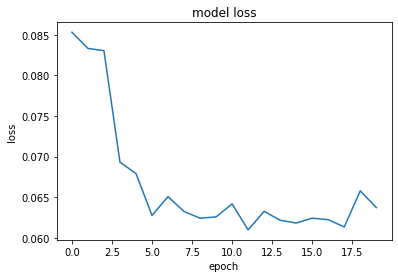

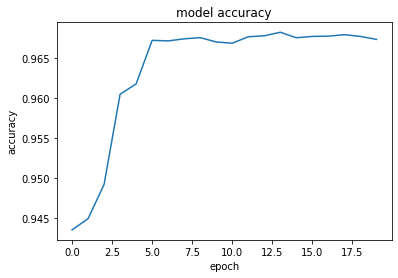

In [26]:
# !pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [19]:
import numpy as np

loaded = keras.models.load_model("my_model")
# np.testing.assert_allclose(loaded(input_arr), outputs)

# print("Original model:", model)
print("Loaded model:", loaded)

Loaded model: <tensorflow.python.keras.engine.functional.Functional object at 0x000002412D9E64A8>


In [31]:
sample = {
    "duration"           : 10,
    "protocol_type"      : 'icmp', 
    "service"            : 'ecr_i', 
    "src_bytes"          : 'SF', 
    "dst_bytes"          : 11, 
    "flag"               : 0, 
    "land"               : 0, 
    'wrong_fragment'     : 0,
    'urgent'             : 0,
    'hot'                : 0,
    'num_failed_logins'  : 0,
    'logged_in'          : 0,
    'num_compromised'    : 0,
    'root_shell'         : 0,
    'su_attempted'       : 0,    
    'num_root'           : 0,
    'num_file_creations' : 1000,
    'num_shells'         : 0,
    'num_access_files'   : 0,
    'num_outbound_cmds'  : 0,
    'is_hot_login'       : 0,
    'is_guest_login'     : 0,
    'count'              : 10,
    'serror_rate'        : 0,
    'rerror_rate'        : 0,
    'same_srv_rate'      : 0,
    'diff_srv_rate'      : 0,
    'srv_count'          : 0,
    'srv_serror_rate'    : 0,
    'srv_rerror_rate'    : 0,
    'srv_diff_host_rate' : 1,
#     'unknown_data1'      : 0,
#     'unknown_data2'      : 0,
#     'unknown_data3'      : 0,
#     'unknown_data4'      : 0,
#     'unknown_data5'      : 0,
#     'unknown_data6'      : 0,
#     'unknown_data7'      : 0,
#     'unknown_data8'      : 0,
#     'unknown_data9'      : 0,
#     'unknown_data10'     : 0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = loaded.predict(input_dict)

print(predictions[0][0]*100,"%")

100.0 %
